# FIT5196 Assessment 2
#### Student Name: Jianhan Ma & Yi Hsiao
#### Student ID: 29332885 & 29360595
#### Group ID: 023
Date: 03/10/2019

Version: 2.0

Environment: Python 3.6.0 and Anaconda 4.3.0 (64-bit)

Libraries used:
* numpy (for data homogeneous multidimensional array, included in Anaconda Python 3.6)
* pandas 0.19.2 (for data frame, included in Anaconda Python 3.6) 
* re 2.2.1 (for regular expression, included in Anaconda Python 3.6) 
* matplotlib (for data visualization, included in Anaconda Python 3.6)
* nmatplotlib.pyplot (for data visualization, included in Anaconda Python 3.6)
* matplotlib.pylab (for stop words, included in Anaconda Python 3.6)
* networkx (for create data model, included in Anaconda Python 3.6)
* seaborn (for data visualization, included in Anaconda Python 3.6)
* LinearRegression(for prediction of data by linear regression )
* train_test_split(for trainning the data )

## Introduction

This task provide three data-set (dirty_data.csv, outlier_data.csv, missing_data.csv). Exploring and understanding the data is one of the most important parts of the data wrangling process. We need to fix the data error in the dirty_data.csv, fill the correct data into the missing_data.csv and find the outlier data and delete it in outlier_data.csv. In addition, we using exploratory data analysis (EDA) method to check data. Because EDA method usually use to visual methods and hypothesis testing task, it will help us to find error data easier.

More details for each task will be given in the following sections.

##   Import libraries 

In [1]:
#Basic scientific python libs
import pandas as pd
import re
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import networkx as nx
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

##  Read files

In [2]:
##read the first csv file
dirty_csv = pd.read_csv("Group023_dirty_data.csv")
missing_csv = pd.read_csv("Group023_missing_data.csv")
outlier_csv = pd.read_csv("Group023_outlier_data.csv")
branches = pd.read_csv("branches.csv")
edges = pd.read_csv("edges.csv", index_col=0)
nodes = pd.read_csv("nodes.csv")

# 1. Dirty Data

## 1.1 Order_ID

Use the function of info to see the information of dirty_csv. There are 12 columns in this file, and each columns have 500 data. Moreover, the data in each columns are non-null.

In [3]:
dirty_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
order_id                   500 non-null object
date                       500 non-null object
time                       500 non-null object
order_type                 500 non-null object
branch_code                500 non-null object
order_items                500 non-null object
order_price                500 non-null float64
customer_lat               500 non-null float64
customer_lon               500 non-null float64
customerHasloyalty?        500 non-null int64
distance_to_customer_KM    500 non-null float64
delivery_fee               500 non-null float64
dtypes: float64(5), int64(1), object(6)
memory usage: 47.0+ KB


In [4]:
## check all the order_id are unique or not
len(dirty_csv['order_id'].unique())

500

## 1.2 date

First of all, use the function of head to check the date's data. We can see that there is a unusual date format in the data.

In [5]:
dirty_csv['date'].head()

0    2018-08-07
1    2018-01-12
2    2018-07-06
3    2018-04-26
4    10-04-2018
Name: date, dtype: object

Use the package of pandas to fix the date type and set the date as string type

In [6]:
##Format the date column
dirty_csv['date'] = pd.to_datetime(dirty_csv['date'].astype(str),dayfirst=True, errors='coerce')

## 1.3 time

In this part, we are going to check whether have the error time type in the data. Firstly, we use the function of split to split the time (hour, minute and second). Then, use the boolean function to check the time type. If the hour less then 24, the minute less then 60, the second less then 60 and the time less then '24:00:00', the system will return true. Whereas, return false.

In [7]:
## to judge the each part of time is in its range or not
def time_valiadation(data):
    time = data['time'].split(':')
    try:
        judge = bool(time[0] < '24' and time[1] < '60' and time[2] < '60' and data['time'] < '24:00:00')
    except ValueError:
        return True
    return False

Use the time_valiadation function to check data. There are no error time type in the data

In [8]:
## apply in dataframe
dirty_csv[dirty_csv.apply(time_valiadation, axis=1)]

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee


## 1.4 Order Type

In this part, we are going to check the order type in the data. We can know correct types of meals in the requirement. (Breakfast - 8am - 12pm, Lunch - 12:00:01pm - 4pm, Dinner - 4:00:01pm - 8pm). However, there are some types occurs on wrong range. Therefore, we set conditions to define correct time range for each order type.

In [9]:
##fix error in order_type column(because some types occurs on wrong time range)
eight = '08:00:00'
twelve = '12:00:00'
sixteen = '16:00:00'
twenty = '20:00:00'
##define a correct time range for each order_type
dirty_csv.loc[((dirty_csv.order_type == "Lunch") | (dirty_csv.order_type == "Dinner")) & (dirty_csv.time <= twelve) & (dirty_csv.time >= eight), "order_type"] = "Breakfast"

dirty_csv.loc[((dirty_csv.order_type == "Breakfast") | (dirty_csv.order_type == "Dinner")) & (dirty_csv.time <= sixteen) & (dirty_csv.time > twelve), "order_type"] = "Lunch"

dirty_csv.loc[((dirty_csv.order_type == "Lunch") | (dirty_csv.order_type == "Breakfast")) & (dirty_csv.time <= twenty) & (dirty_csv.time > sixteen), "order_type"] = "Dinner"

Detect the data whether has been fixed.

In [10]:
## detect the wrong data has been fixed or not
dirty_csv[(dirty_csv.order_type == "Breakfast") & (dirty_csv.time > twelve)]

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee


## 1.5 Branch code

In this part, we are going to see the information of branch code. If the data of branch code have error type, must be fix it.
We found a relationship between `order_id` and `branch_code` from outlier csv Because the data in this file has no data anomalies, only outliers. 

In [11]:
def get_correct_code(data):
    order_id = data['order_id']
    id_list = re.findall(r'([A-Z]*)', order_id)
    return str(id_list[0])

In [12]:
outlier_csv['id_list'] = outlier_csv.apply(get_correct_code, axis = 1)

In [13]:
outlier_csv.loc[(outlier_csv.branch_code == 'NS'),'id_list'].value_counts()

ORDC    62
ORDI    60
ORDZ    47
Name: id_list, dtype: int64

In [14]:
outlier_csv.loc[(outlier_csv.branch_code == 'BK'),'id_list'].value_counts()

ORDX    58
ORDK    49
ORDA    47
Name: id_list, dtype: int64

In [15]:
outlier_csv.loc[(outlier_csv.branch_code == 'TP'),'id_list'].value_counts()

ORDB    62
ORDJ    58
ORDY    57
Name: id_list, dtype: int64

In [16]:
outlier_csv = outlier_csv.drop(columns = 'id_list')

So here we can fix the errors of branch code by following the relationship from the code above.

In [17]:
dirty_csv.loc[(dirty_csv['order_id'].str.contains(r'[CIZ]')) & (dirty_csv['branch_code'] != 'NS'), 'branch_code'] = 'NS'
dirty_csv.loc[(dirty_csv['order_id'].str.contains(r'[XKA]')) & (dirty_csv['branch_code'] != 'BK'), 'branch_code'] = 'BK'
dirty_csv.loc[(dirty_csv['order_id'].str.contains(r'[BJY]')) & (dirty_csv['branch_code'] != 'TP'), 'branch_code'] = 'TP'

In [18]:
branches.head()

,branch_code,branch_name,branch_lat,branch_lon
0,NS,Nickolson,-37.773803,144.983647
1,TP,Thompson,-37.861835,144.905716
2,BK,Bakers,-37.815834,145.046450


Check each branch code and count it. We find that there are lowercase and uppercase in the data

In [19]:
## to find the frequency of each kind of value
dirty_csv.branch_code.value_counts()

TP    173
NS    172
BK    155
Name: branch_code, dtype: int64

We chahge all of branch code into uppercase

In [20]:
##upper case all the branch code
dirty_csv.branch_code = dirty_csv.branch_code.str.upper()
dirty_csv.branch_code.value_counts()

TP    173
NS    172
BK    155
Name: branch_code, dtype: int64

## 1.6 Order item

In this part, we are going to find the correct menu for each type form missing value. Firstly, we use the `missing_csv` to find the correct menu, because there is no data anomalies in the `missing_csv`. Secondly, we use the function of loop and the function of re (regular expression) to extract the correct data. Finaly, append the extracted data to a new list, then use the function of set to remove duplication

### 1.6.1 Menu for breakfast, lunch and dinner

In [21]:
##get the correct menu for each type from missing value(becaues there is no data anomalies)

breakfast_item = missing_csv[(missing_csv.order_type == "Breakfast")]['order_items'].tolist()
breakfast_menu=[]
for i in range(len(breakfast_item)):
    menu = []
    menu = re.findall('([A-Z]\w+)', breakfast_item[i]) ## get the item from srting or we can use eval() to get the first element.
    for item in menu:
        breakfast_menu.append(item)
breakfast_menu = list(set(breakfast_menu))


lunch_item = missing_csv[(missing_csv.order_type == "Lunch")]['order_items'].tolist()
lunch_menu=[]
for i in range(len(lunch_item)):
    menu = []
    menu = re.findall('([A-Z]\w+)', lunch_item[i])
    for item in menu:
        lunch_menu.append(item)
lunch_menu = list(set(lunch_menu))



dinner_item = missing_csv[(missing_csv.order_type == "Dinner")]['order_items'].tolist()
dinner_menu=[]
for i in range(len(dinner_item)):
    menu = []
    menu = re.findall('([A-Z]\w+\&?[A-Z]?\w+)', dinner_item[i])
    for item in menu:
        dinner_menu.append(item)
dinner_menu = list(set(dinner_menu))

Then, print the correct menu for each type

In [22]:
print('breakfast menu: ' + str(breakfast_menu))
print('lunch menu: '+ str(lunch_menu))
print('dinner menu: '+ str(dinner_menu))

breakfast menu: ['Pancake', 'Coffee', 'Cereal', 'Eggs']
lunch menu: ['Salad', 'Burger', 'Fries', 'Chicken', 'Steak']
dinner menu: ['Fish&Chips', 'Salmon', 'Pasta', 'Shrimp']


### 1.6.2 Menu price

In this part, we are going to find the price of items in each menu 

### Breakfast item menu

First of all, use the eval method to transform string to a format. Because this methos allows us to be more convenient in calculations.

In [23]:
##use eval() method to transform string to a format which is looks like
def turnto_list(data):
    data['order_items'] = eval(data['order_items'])
    return data['order_items']

Then, We are going to find the number of order items in each data. We use two loops to solve this problem. The first loop to run the length of `breakfast_menu` and the second loop to run the length of `order_item`. If the 0th position of `order_item` matches `breakfast_menu`, the list of `item_pric`e will append the 1th position of `order_item's` data which is the amount of items.

In [24]:
## to get all the amount of items order by its menu 
def get_amount_bf(data):
    order_item = data['order_items']
    item_price = []
    for x in range(len(breakfast_menu)):
        for i in range(len(order_item)):
            if breakfast_menu[x] == order_item[i][0]:
                item_price.append(order_item[i][1])
    return item_price

Finally, we just only get the column which has 4 `order_items`. Because, there are only 4 items in the breakfast menu. Therefore, only get the data which has 4 `order_items` makes it easier for us to calculate the price of each item (4 functions, 4 variables).

In [25]:
## only get the colunm which has 4 order_items
missing_csv_4items_bf = missing_csv[(missing_csv.order_type=='Breakfast') & (missing_csv.order_items.str.len() > 50) ][['order_type','order_items','order_price']]
missing_csv_4items_bf['order_items'] = missing_csv_4items_bf.apply(turnto_list, axis = 1)
missing_csv_4items_bf.loc[(missing_csv_4items_bf.order_type=='Breakfast'),'item_price_bf'] = missing_csv_4items_bf.apply(get_amount_bf, axis = 1)
missing_csv_4items_bf = missing_csv_4items_bf.head(4)## Four unknowns should have four equations

Then, we can see that there is a new column to record the amount of each item. These data will be sorted by `breakfast_menu` (['Eggs', 'Pancake', 'Coffee', 'Cereal']).

In [26]:
missing_csv_4items_bf.head(4)

,order_type,order_items,order_price,item_price_bf
15,Breakfast,"[(Pancake, 10), (Eggs, 9), (Cereal, 1), (Coffe...",491.50,"[10, 4, 1, 9]"
19,Breakfast,"[(Pancake, 5), (Eggs, 8), (Coffee, 7), (Cereal...",538.75,"[5, 7, 9, 8]"
21,Breakfast,"[(Eggs, 7), (Pancake, 3), (Cereal, 8), (Coffee...",439.75,"[3, 6, 8, 7]"
26,Breakfast,"[(Pancake, 6), (Cereal, 8), (Coffee, 10), (Egg...",586.50,"[6, 10, 8, 9]"


In [27]:
breakfast_menu

['Pancake', 'Coffee', 'Cereal', 'Eggs']

In this part, we are going to calculate the price of each item. Firstly, we get a Two-dimensional list from `missing_csv_4items_bf`, then transform Two-dimensional list to Two-dimensional array. Secondly, get the `order_price` and turn to array. Finaly, use the `np.linalg.solve` method to caculate the equation, then add the cach item and each price into a dictionary.

In [28]:
br_menu_price = {}
bf_amount = []

##get a Two-dimensional list
for i in missing_csv_4items_bf.index.values:
    bf_amount.append(missing_csv_4items_bf['item_price_bf'][i])
    
## transform Two-dimensional list to Two-dimensional array
for x in range(len(bf_amount)):
    bf_amount[x] = np.array(bf_amount[x])
bf_amount = np.array(bf_amount)

##get the order_price and turn to array
bf_price = np.array(missing_csv_4items_bf['order_price'])

##to Solution equation
bf_unit_price = np.linalg.solve(bf_amount, bf_price)

## add the item and its price into a dictionary
for i in range(len(breakfast_menu)):
    br_menu_price[breakfast_menu[i]] = round(bf_unit_price[i],2)
br_menu_price

{'Pancake': 24.25, 'Coffee': 7.5, 'Cereal': 21.0, 'Eggs': 22.0}

### Lunch item price

Then, We are going to find the number of order items in each data. We use two loops to solve this problem. The first loop to run the length of `lunch_menu` and the second loop to run the length of `order_item`. If the 0th position of `order_item` matches `lu_menu`,nch the list of `item_pric`e will append the 1th position of `order_item's` data which is the amount of items.

In [29]:
def get_amount_lu(data):
    order_item = data['order_items']
    item_price = []
    for x in range(len(lunch_menu)):
        for i in range(len(order_item)):
            if lunch_menu[x] == order_item[i][0]:
                item_price.append(order_item[i][1])
    return item_price

Finally, we just only get the column which has 5 order_items. Because, there are only 4 items in the lunch menu. Therefore, only get the data which has 5 order_items makes it easier for us to calculate the price of each item (4 functions, 4 variables).

In [30]:
missing_csv_4items_lu = missing_csv[(missing_csv.order_type=='Lunch') & (missing_csv.order_items.str.len() > 60) ][['order_type','order_items','order_price']]
missing_csv_4items_lu['order_items'] = missing_csv_4items_lu.apply(turnto_list, axis = 1)
missing_csv_4items_lu.loc[(missing_csv_4items_lu.order_type=='Lunch'),'item_price_lu'] = missing_csv_4items_lu.apply(get_amount_lu, axis = 1)
missing_csv_4items_lu = missing_csv_4items_lu.head()

In [31]:
print(lunch_menu)

['Salad', 'Burger', 'Fries', 'Chicken', 'Steak']


In this part, we are going to calculate the price of each item. Firstly, we get a Two-dimensional list from `missing_csv_4items_bf`, then transform Two-dimensional list to Two-dimensional array. Secondly, get the `order_price` and turn to array. Finaly, use the `np.linalg.solve` method to caculate the equation, then add the cach item and each price into a dictionary.

In [32]:
lu_menu_price = {}
lu_amount = []
for i in missing_csv_4items_lu.index.values:
    lu_amount.append(missing_csv_4items_lu['item_price_lu'][i])

for x in range(len(lu_amount)):
    lu_amount[x] = np.array(lu_amount[x])
lu_amount = np.array(lu_amount)

lu_price = np.array(missing_csv_4items_lu['order_price'])

lu_unit_price = np.linalg.solve(lu_amount, lu_price)

for i in range(len(lunch_menu)):
    lu_menu_price[lunch_menu[i]] = round(lu_unit_price[i],2)
lu_menu_price

{'Salad': 17.2, 'Burger': 31.0, 'Fries': 12.0, 'Chicken': 32.0, 'Steak': 45.0}

### Dinner item price

Then, We are going to find the number of order items in each data. We use two loops to solve this problem. The first loop to run the length of `dinner_menu` and the second loop to run the length of `order_item`. If the 0th position of `order_item` matches `dinner_menu`, the list of `item_price` will append the 1th position of `order_item's` data which is the amount of items.

In [33]:
def get_amount_di(data):
    order_item = data['order_items']
    item_price = []
    for x in range(len(dinner_menu)):
        for i in range(len(order_item)):
            if dinner_menu[x] == order_item[i][0]:
                item_price.append(order_item[i][1])
    return item_price

Finally, we just only get the column which has 4 order_items. Because, there are only 4 items in the dinner menu. Therefore, only get the data which has 4 order_items makes it easier for us to calculate the price of each item (4 functions, 4 variables).

In [34]:
missing_csv_4items_di = missing_csv[(missing_csv.order_type=='Dinner') & (missing_csv.order_items.str.len() > 50) ][['order_type','order_items','order_price']]
missing_csv_4items_di['order_items'] = missing_csv_4items_di.apply(turnto_list, axis = 1)
missing_csv_4items_di.loc[(missing_csv_4items_di.order_type=='Dinner'),'item_price_di'] = missing_csv_4items_di.apply(get_amount_di, axis = 1)
missing_csv_4items_di = missing_csv_4items_di.head(4)

In [35]:
print(dinner_menu)

['Fish&Chips', 'Salmon', 'Pasta', 'Shrimp']


In this part, we are going to calculate the price of each item. Firstly, we get a Two-dimensional list from `missing_csv_4items_bf`, then transform Two-dimensional list to Two-dimensional array. Secondly, get the `order_price` and turn to array. Finaly, use the `np.linalg.solve` method to caculate the equation, then add the cach item and each price into a dictionary.

In [36]:
di_menu_price = {}
di_amount = []
for i in missing_csv_4items_di.index.values:
    di_amount.append(missing_csv_4items_di['item_price_di'][i])

for x in range(len(di_amount)):
    di_amount[x] = np.array(di_amount[x])
di_amount = np.array(di_amount)

di_price = np.array(missing_csv_4items_di['order_price'])

di_unit_price = np.linalg.solve(di_amount, di_price)

for i in range(len(dinner_menu)):
    di_menu_price[dinner_menu[i]] = round(di_unit_price[i],2)
di_menu_price

{'Fish&Chips': 35.0, 'Salmon': 41.0, 'Pasta': 27.5, 'Shrimp': 54.0}

Finally, we can see that each items and it price in each menus

In [37]:
print('breakfast_menu:',br_menu_price)
print('lunch_menu:',lu_menu_price)
print('dinner_menu:',di_menu_price)

breakfast_menu: {'Pancake': 24.25, 'Coffee': 7.5, 'Cereal': 21.0, 'Eggs': 22.0}
lunch_menu: {'Salad': 17.2, 'Burger': 31.0, 'Fries': 12.0, 'Chicken': 32.0, 'Steak': 45.0}
dinner_menu: {'Fish&Chips': 35.0, 'Salmon': 41.0, 'Pasta': 27.5, 'Shrimp': 54.0}


### replace the wrong menu in dirty csv

In this part, we are going to replace the wrong item in each data. Firstly, transfer list and tuple to a dictionary and get the wrong item which should not appear in this order_items. Secondly, use the two function of loops to check the data. First loop use to caculate the price of wrong item. If it has wrong item in each data, get sum of the price of right items from `br_menu_price`, then cacluate the price of the wrong item (the price of wrong item - sum of the price of right item). Second loop use to the ratio of the correct number of items to the number of wrong items. If the data can be divisible by value, we can get the ratio of the correct number of items to the number of wrong items and the result number of the right items. Finally, remove the wrong item from this `order_items` and return to the list format


In [38]:
dirty_csv['order_items'] = dirty_csv.apply(turnto_list, axis = 1)

In [39]:
def replace_wrong_item(data):
    dict_menu = dict(data['order_items']) ## tranform list and tuple to a dictionary
    if data['order_type'] == 'Breakfast':
        
        wrong_item = list(set(dict_menu.keys()) - set(breakfast_menu)) ## get the wrong item which should not appear in this order_items
        price = 0 ##initialize price
        if len(wrong_item) == 1: ## if it has wrong item
            
            for key, value in dict_menu.items():
                if key != wrong_item[0]: 
                    price += int(value) * br_menu_price[key].item()##get sum of the price of right items
            right_item_price = (data['order_price'] - price)/int(dict_menu[wrong_item[0]])## caculate the price of the wrong item
            
            for key,value in br_menu_price.items():
                if right_item_price % value == 0: ##If the result of the calculation just can be divisible
                    result = right_item_price/value ## Get the ratio of the correct number of items to the number of wrong items
                    
                    dict_menu[key] = int(dict_menu[wrong_item[0]])*int(result) ## and we get the result number of the right items and append in the 'order_item'
                    
            del dict_menu[wrong_item[0]] ## remove the wrong item from this order_items
            right_order_bf = list(dict_menu.items()) ##return a orginal format
            return right_order_bf
                    
        else: ##if we don't have error for this row, return orginal data
            return data['order_items']
        
        
    ## the following code is similar as the 'Breakfast'    
    elif data['order_type'] == 'Lunch':
        
        wrong_item = list(set(dict_menu.keys()) - set(lunch_menu))

        price = 0
        if len(wrong_item) == 1:
            for key, value in dict_menu.items():
                if key != wrong_item[0]:
                    price += int(value) * lu_menu_price[key].item()
            right_item_price = (data['order_price'] - price)/int(dict_menu[wrong_item[0]])
            for key,value in lu_menu_price.items():
                if right_item_price % value == 0:
                    result = right_item_price/value
                    
                    dict_menu[key] = int(dict_menu[wrong_item[0]])*int(result)
                   
            del dict_menu[wrong_item[0]]
            right_order_lu = list(dict_menu.items())
            return right_order_lu
                    
        else:
            return data['order_items']
        
        
       ## 'Dinner' part 
    elif data['order_type'] == 'Dinner':
        
        wrong_item = list(set(dict_menu.keys()) - set(dinner_menu))

        price = 0
        if len(wrong_item) == 1:
            for key, value in dict_menu.items():
                if key != wrong_item[0]:
                    price += int(value) * di_menu_price[key].item()
            right_item_price = (data['order_price'] - price)/int(dict_menu[wrong_item[0]])
            for key,value in di_menu_price.items():
                if right_item_price % value == 0:
                    result = right_item_price/value
                    
                    dict_menu[key] = int(dict_menu[wrong_item[0]])*int(result)
                   
            del dict_menu[wrong_item[0]]
            right_order_di = list(dict_menu.items())
            return right_order_di
                    
        else:
            return data['order_items']

In [40]:
dirty_csv['order_items'] = dirty_csv.apply(replace_wrong_item, axis=1)

Here is a valiadation function to check wether a order_item include item comes from other order_type. So if it has other items, return 1, otherwise, return 0. So we can sum up the values in new column which store the values. Finally, we found there is no errors after fixing,

In [41]:
## Check wether it has error or not after modified
def check_order_item(data):
    dict_menu = dict(data['order_items'])
    if data['order_type'] == 'Breakfast':
        for key in dict_menu.keys():
            if key in lunch_menu or key in dinner_menu:
                return 1
            else:
                return 0
            
    elif data['order_type'] == 'Lunch':
        for key in dict_menu.keys():
            if key in breakfast_menu or key in dinner_menu:
                return 1
            else:
                return 0
            
    elif data['order_type'] == 'Dinner':
        for key in dict_menu.keys():
            if key in breakfast_menu or key in lunch_menu:
                return 1
            else:
                return 0

In [42]:
dirty_csv['order_items_has_error?'] = dirty_csv.apply(check_order_item, axis=1)

In [43]:
dirty_csv.loc[dirty_csv['order_items_has_error?']==0,'order_items_has_error?'].sum(axis=0)

0

## 1.7 Order_price

In this part, we are going to see whether the data of `order_price` have errors. Use the `describe` function to see the detail information of `order_price`

In [44]:
dirty_csv['order_price'].describe()

count     500.000000
mean      499.384900
std       273.778058
min        46.400000
25%       287.000000
50%       447.300000
75%       673.500000
max      1465.500000
Name: order_price, dtype: float64

First of all, put the data of `order_items` into a dictionary. Then use the function of loop to run each items. If `order_type` is Breakfast, the price will plus each value times the position of menu. In addition, if the difference greater than 5, the price will be changed.

In [45]:
##modify the order_price
def change_price(data):
    items = dict(data['order_items'])
    price = 0
    
    for key,value in items.items():
        if data['order_type'] == 'Breakfast':
            price += value * br_menu_price[key]
        elif data['order_type'] == 'Lunch':
            price += value * lu_menu_price[key]
        elif data['order_type'] == 'Dinner':
            price += value * di_menu_price[key]
    if abs(data['order_price'] - price) > 5: ##if the difference greater than 5, change the price
        return round(price,2)
    else:
        return data['order_price']

In [46]:
dirty_csv['order_price'] = dirty_csv.apply(change_price, axis = 1)

In [47]:
dirty_csv['order_price'].describe()

count     500.000000
mean      505.111100
std       274.500359
min        46.400000
25%       294.375000
50%       455.500000
75%       687.200000
max      1465.500000
Name: order_price, dtype: float64

## 1.8 Customer lat & lon

In this part, we are going to find the error in `customer_lat` and `customer_lon`, then fix it. Use the `describe` method to see the detail information about the data of `customer_lat` and `customer_lon`.

In [48]:
dirty_csv[['customer_lat','customer_lon']].describe()

,customer_lat,customer_lon
count,500.000000,500.000000
mean,-30.754307,143.505950
std,25.336874,16.299322
min,-37.827411,-37.822145
25%,-37.818698,144.952854
50%,-37.812172,144.966351
75%,-37.804828,144.983149
max,145.002764,145.016299


Use the package of `plt.subplot` to find the wrong value 

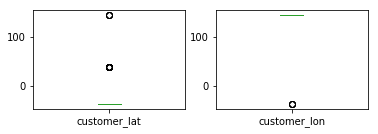

In [49]:
## find the wrong value by plot
plt.subplot(2,2,1)
dirty_csv.customer_lat.plot.box()
plt.subplot(2,2,2)
dirty_csv.customer_lon.plot.box()
plt.show()

Then, set conditions to fix the error data. If `customer_lat` greater then 0 and `customer_lat` less than 40, it will add a negative mark if latitude is positive. If the `customer_lat` greater than 144, the data of `customer_lat` and the data of `customer_lon` will be exchanged.

In [50]:
def modify_location(data):
    lat = data['customer_lat']
    lon = data['customer_lon']
    
    if lat > 0 and lat < 40: ## add a negative mark if latitude is positive
        return lat*(-1),lon
    
    elif lat > 144: ## exchange latitude and longitude
        return lon,lat
    
    else:
        return lat,lon

Finally, apply the fixed data. Then, use the `plt.subplot` to check the data

In [51]:
dirty_csv[['customer_lat','customer_lon']] = dirty_csv.apply(lambda data:pd.Series(modify_location(data)), axis = 1)

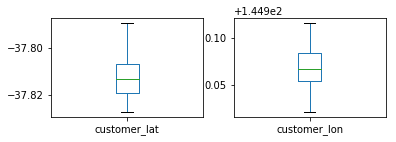

In [52]:
##check the data after modified
plt.subplot(2,2,1)
dirty_csv.customer_lat.plot.box()
plt.subplot(2,2,2)
dirty_csv.customer_lon.plot.box()
plt.show()

## 1.9 customerHasloyalty?

In this part, we are going to check whether the customerHasloyalty have errors.

In [53]:
## check wether it has other value except 0 and 1
dirty_csv[(dirty_csv['customerHasloyalty?'] != 0) & (dirty_csv['customerHasloyalty?'] != 1)]

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee,order_items_has_error?


## 1.10 distance_to_customer_KM

In this part, we are going to find the correct data about `distance_to_customer_KM` by `shortest distance` method. First of all, check the detail information about `distance_to_customer_KM`

In [54]:
dirty_csv['distance_to_customer_KM'].describe()

count    500.000000
mean       8.701362
std        1.621212
min        4.077000
25%        7.726000
50%        8.788000
75%        9.840250
max       12.892000
Name: distance_to_customer_KM, dtype: float64

In [55]:
branches.head()

,branch_code,branch_name,branch_lat,branch_lon
0,NS,Nickolson,-37.773803,144.983647
1,TP,Thompson,-37.861835,144.905716
2,BK,Bakers,-37.815834,145.046450


In [56]:
nodes.head()

,node,lat,lon
0,711327755,-37.807675,144.955873
1,711327756,-37.807094,144.955978
2,711327759,-37.807301,144.957817
3,711327760,-37.807885,144.957719
4,777781264,-37.805221,144.952173


Due to calculating the shortest distance need the data information in the three files `nodes.csv`, `branches.csv`, and `dirty.csv`, we use the function of `pd.merge` to merge files.

In [57]:
## merge nodes.csv and branches.csv
branches = pd.merge(branches, nodes, how = 'left', left_on = ['branch_lat', 'branch_lon'], right_on = ['lat','lon'])
branches = branches.drop(columns = ['lat','lon'])
branches = branches.rename(columns={'node': 'branch_node'})

In [58]:
## merge branches.csv and dirty.csv
dirty_csv = pd.merge(dirty_csv, branches, how = 'left', on = 'branch_code')
dirty_csv = pd.merge(dirty_csv, nodes, how = 'left', left_on = ['customer_lat','customer_lon'], right_on = ['lat','lon'])
dirty_csv = dirty_csv.drop(columns = ['lat','lon','branch_lat','branch_lon'])
dirty_csv = dirty_csv.rename(columns={'node': 'customer_node'})

In [59]:
dirty_csv.head()

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee,order_items_has_error?,branch_name,branch_node,customer_node
0,ORDC01406,2018-08-07,15:16:03,Lunch,NS,"[(Fries, 6), (Salad, 4)]",140.80,-37.812539,144.954121,1,8.335,13.700428,0,Nickolson,2455254505,6167279389
1,ORDZ10125,2018-01-12,08:20:16,Breakfast,NS,"[(Cereal, 8), (Pancake, 6)]",313.50,-37.809310,144.972170,1,7.536,6.167473,0,Nickolson,2455254505,277089929
2,ORDZ04175,2018-07-06,14:05:04,Lunch,NS,"[(Steak, 3), (Salad, 1), (Chicken, 6), (Fries,...",640.20,-37.820482,144.994806,0,9.860,15.088928,0,Nickolson,2455254505,3804564097
3,ORDI03691,2018-04-26,11:43:05,Breakfast,NS,"[(Pancake, 9), (Eggs, 10), (Cereal, 2)]",480.25,-37.818697,144.965774,0,8.614,13.684368,0,Nickolson,2455254505,591435981
4,ORDZ04094,2018-04-10,11:12:40,Breakfast,NS,"[(Eggs, 5), (Coffee, 3), (Pancake, 9), (Cereal...",497.75,-37.820609,144.966868,0,8.802,13.760744,0,Nickolson,2455254505,154044549


Create the bilateral edges and define the weight to calculate the time (`(distance(m) / 1000)/speed(km/h))`. Then, define network. Finally, add nodes in each data and add the relationship and weight for each line.

In [60]:
##create the bilateral edges
edges = pd.concat([edges,edges.rename(columns = {'u':'v', 'v':'u'})])
##define the weight
edges['time(h)'] = (edges['distance(m)']/1000)/edges['speed(km/h)']
#define network
G=nx.DiGraph()
row=edges.u.values
col=edges.v.values
value=edges['time(h)'].values
node = nodes['node'].values

##add nodes
for i in node:
    G.add_node(i)

##add the relationship and weight for each line
for i in range(np.size(row)):
    G.add_weighted_edges_from([(row[i],col[i],value[i])])
        

C:\Users\xxxx\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In the `find_shortest_distance` method, we set the time consumption as the weight of a road(two nodes). But the shortest distance is the ideal output that we want. So there is a methodology I used is using `for` loop to get all the roads from the `path`, and find the distance of this roda to sum up. (the `for` loop should be start with `i-1` not `i`. Because if we set start is `i`, there will be errors when calculating the path). Finally, we use the function of `abs` and set a condition to caculate data. If the caculated data minus the distance which in `distance_to_customer_KM` greate than 0.5, return the distance / 1000.

In [61]:
def find_shortest_distance(data):
    start_point = data['branch_node']
    end_point = data['customer_node']
    path = nx.dijkstra_path(G, source = start_point, target = end_point)##get a list contains the path
    
    distance = 0
    
    for i in range(1,len(path)):## to caculate the shortest distance between two nodes
        start = path[i-1]
        end = path[i]
        distance += int(edges[(edges.u == start) & (edges.v == end)]['distance(m)'].tolist()[0])
 
    if abs(distance/1000 - data['distance_to_customer_KM']) > 0.5: ## if the difference is greater than
        return round(distance/1000,3)
    else:
        return data['distance_to_customer_KM']


Apply the fixed data and use the function of `describe` to see the detail information.

In [62]:
dirty_csv['distance_to_customer_KM'] = dirty_csv.apply(find_shortest_distance, axis = 1)

In [63]:
dirty_csv['distance_to_customer_KM'].describe()

count    500.000000
mean       8.725774
std        1.644218
min        4.077000
25%        7.731000
50%        8.814000
75%        9.840250
max       13.939000
Name: distance_to_customer_KM, dtype: float64

## 1.11 delivery fee

In this part, we check the data by data visualzation. Use the function of `sns.pairplot` to see each branch's distribution status (x-asis : `distance_to_customer_KM`, y-axis : `delivery_fee`, point color : `customerHasloyalty?`

C:\Users\xxxx\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
C:\Users\xxxx\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
C:\Users\xxxx\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


<Figure size 432x288 with 0 Axes>

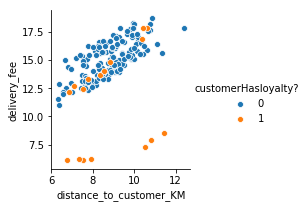

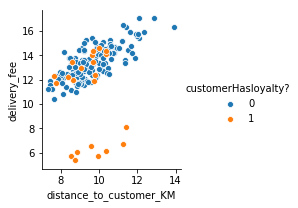

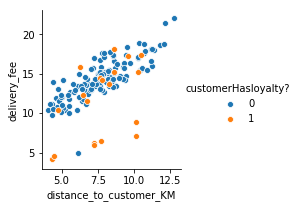

In [64]:
plt.figure()
_ = sns.pairplot(data = dirty_csv[dirty_csv['branch_code'] == 'NS'], x_vars = 'distance_to_customer_KM', y_vars = 'delivery_fee',
                hue = 'customerHasloyalty?', size = 3)
_ = sns.pairplot(data = dirty_csv[dirty_csv['branch_code'] == 'TP'], x_vars = 'distance_to_customer_KM', y_vars = 'delivery_fee',
                hue = 'customerHasloyalty?', size = 3)
_ = sns.pairplot(data = dirty_csv[dirty_csv['branch_code'] == 'BK'], x_vars = 'distance_to_customer_KM', y_vars = 'delivery_fee',
                hue = 'customerHasloyalty?', size = 3)
plt.show()

## 1.12 Save into file

Delete does not needed column and save the fixed data into file

In [65]:
dirty_csv = dirty_csv.drop(columns= ['order_items_has_error?','branch_name','branch_node','customer_node'])

In [66]:
dirty_csv.to_csv('Group023_dirty_data_solution.csv')

# 2. Missing data

In this section, we are going to fill the missing data. In addition, We use the exploratory data analysis (EDA) method to find the error. First of all, use the function of isnull to see which column have nulls

## 2.1 Fill branch_code

In [67]:
missing_csv.isnull().sum(axis=0)

order_id                     0
date                         0
time                         0
order_type                   0
branch_code                100
order_items                  0
order_price                  0
customer_lat                 0
customer_lon                 0
customerHasloyalty?          0
distance_to_customer_KM     50
delivery_fee                50
dtype: int64

Here we can fill the missing value of branch code by following the relationship from the information that we figured it out above.

In [68]:
missing_csv.loc[(missing_csv['order_id'].str.contains(r'[CIZ]')), 'branch_code'] = 'NS'
missing_csv.loc[(missing_csv['order_id'].str.contains(r'[XKA]')), 'branch_code'] = 'BK'
missing_csv.loc[(missing_csv['order_id'].str.contains(r'[BJY]')), 'branch_code'] = 'TP'

In [69]:
missing_csv.isnull().sum(axis=0)

order_id                    0
date                        0
time                        0
order_type                  0
branch_code                 0
order_items                 0
order_price                 0
customer_lat                0
customer_lon                0
customerHasloyalty?         0
distance_to_customer_KM    50
delivery_fee               50
dtype: int64

## 2.2 fill distance_to_customer_KM

First of all, we have to know branch_node and customer_node if we want to caculate the shortest distance between branch and customer. So there is one way we can do is merge three csv file(`missing.csv`,`branches.csv`,`nodes.csv`). And then input two nodes in each iteration to return the distance.

In [70]:
##merge three files to get branch_node and customer_node
missing_csv = pd.merge(missing_csv, branches, how = 'left', on = 'branch_code')
missing_csv = pd.merge(missing_csv, nodes, how = 'left', left_on = ['customer_lat','customer_lon'], right_on = ['lat','lon'])
missing_csv = missing_csv.drop(columns = ['lat','lon','branch_lat','branch_lon'])
missing_csv = missing_csv.rename(columns={'node': 'customer_node'})

In [71]:
def find_shortest_distance_new(data):
    start_point = data['branch_node']
    end_point = data['customer_node']
    path = nx.dijkstra_path(G, source = start_point, target = end_point)##get a list contains the path
    
    distance = 0
    
    for i in range(1,len(path)):## to caculate the shortest distance between two nodes
        start = path[i-1]
        end = path[i]
        distance += int(edges[(edges.u == start) & (edges.v == end)]['distance(m)'].tolist()[0])
 
    return round(distance/1000,3)


In [72]:
missing_csv.loc[missing_csv['distance_to_customer_KM'].isnull(),'distance_to_customer_KM'] = \
                                                    missing_csv[missing_csv['distance_to_customer_KM'].isnull()].apply(find_shortest_distance_new,axis = 1)

Now we have filled all distance value, and then we have one more column(delivery_fee) need to be filled.

In [73]:
missing_csv.isnull().sum(axis=0)

order_id                    0
date                        0
time                        0
order_type                  0
branch_code                 0
order_items                 0
order_price                 0
customer_lat                0
customer_lon                0
customerHasloyalty?         0
distance_to_customer_KM     0
delivery_fee               50
branch_name                 0
branch_node                 0
customer_node               0
dtype: int64

## 2.3 Fill delivery_fee

Create a column to store a value which stand for which day in a week, '0' stand for Monday. Then use a condition to define `dayofweek`. If weekday will return 0 whereas weekend will return 1

In [74]:
##create a column to store a value which stand for which day in a week, '0' stand for Monday
missing_csv['dayofweek'] = pd.to_datetime(missing_csv['date']).dt.dayofweek

In [75]:
## if weekday, return 0. if weekend, return 1
def weekday(data):
    dayofweek = data['dayofweek']
    if dayofweek > 4:
        return 1
    if dayofweek <= 4:
        return 0

Apply fixed data

In [76]:
missing_csv['weekday_or_weekend'] = missing_csv.apply(weekday, axis = 1)

Use conditions to define `order_type`. If the `timeofday` is Breakfast will return 0. If afternoon, return 1. If evening, return 2

In [77]:
## if morning, return 0; if afternoon, return 1; if evening, return 2
def time_of_day(data):
    timeofday = data['order_type']
    if timeofday == 'Breakfast':
        return 0
    if timeofday == 'Lunch':
        return 1
    if timeofday == 'Dinner':
        return 2

Apply fixed data

In [78]:
missing_csv['time_day'] = missing_csv.apply(time_of_day, axis = 1)

In this part, we are going to caculate the delivery fee in each data. Then, we create a dataframe without NA to train the linear model for delivery fee. Because, if the dataframe have nulls, the result will error. 

In [79]:
##create a dataframe without NA to train the linear model for delivery fee
missing_dropna = missing_csv.dropna(axis=0, how='any', inplace=False)

Then, delivery fee multiply 2 if this customer has loyalty

In [80]:
## delivery fee multiply 2 if this customer has loyalty
missing_dropna.loc[missing_dropna['customerHasloyalty?'] ==1, 'delivery_fee'] = \
        missing_dropna.loc[missing_dropna['customerHasloyalty?']==1, 'delivery_fee'] * 2

C:\Users\xxxx\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


## Linear model for the delivery fee of NS branch and fill missing value

Use liner model to caculate the delivery fee of NS branch

In [81]:
##get all the row which is belong to NS
missing_dropna_ns = missing_dropna[missing_dropna['branch_code'] == 'NS']

Use three columns(dayofweek, time_day, distance) to train linear model. Then use the function of map to store the data. 

In [82]:
##use three columns(dayofweek, time_day, order_price) to train linear model
x_train, x_test, y_train, y_test = train_test_split(missing_dropna_ns.iloc[:,[16,17,10]],\
                                                    missing_dropna_ns['delivery_fee'], test_size = 0.2, random_state = 0)
list(map(pd.np.shape,[x_train, x_test, y_train, y_test]))

[(122, 3), (31, 3), (122,), (31,)]

Use the `LinearRegression()` method to get the most accurate linear fit.

In [83]:
## adjust test_size to get the most accurate linear fit.
lm_model_ns = LinearRegression()
lm_model_ns.fit(x_train, y_train)
print('R-squared for this model is : ',lm_model_ns.score(x_test, y_test))

R-squared for this model is :  0.9800099578140492


If the `delivery_fee` is null and the `branch_code` is NS, get the predict value by using linear model. In addition, if customer has loyalty, deliver fee will multiply 0.5(has 50% discount)

In [84]:
miss_na_ns = missing_csv[(missing_csv['delivery_fee'].isnull()) & (missing_csv['branch_code'] =='NS')].iloc[:,[9,16,17,10]]
##get the predict value by using linear model
miss_na_ns['p_delivery_fee'] = lm_model_ns.predict(miss_na_ns.iloc[:,1:])
## if customer has loyalty, deliver fee will multiply 0.5(has 50% discount)
miss_na_ns.loc[miss_na_ns['customerHasloyalty?'] == 1, 'p_delivery_fee'] = \
                                        miss_na_ns.loc[miss_na_ns['customerHasloyalty?'] ==1, 'p_delivery_fee']*0.5

miss_na_ns.head()

,customerHasloyalty?,weekday_or_weekend,time_day,distance_to_customer_KM,p_delivery_fee
42,0,0,2,9.171,15.130082
50,0,0,1,6.832,12.299287
65,0,1,0,8.237,15.278559
123,1,1,0,10.029,8.547567
131,0,0,2,6.796,12.722512


Finally, fill the data into null cells. Then, we can use the function of isnull to check again the amount of null. We can see that `delivery_fee` reduce by 19.

In [85]:
## fill na
missing_csv.loc[(missing_csv['delivery_fee'].isnull()) & (missing_csv['branch_code'] == 'NS'), 'delivery_fee'] = \
                                                                                                    miss_na_ns['p_delivery_fee']

In [86]:
missing_csv.isnull().sum(axis=0)

order_id                    0
date                        0
time                        0
order_type                  0
branch_code                 0
order_items                 0
order_price                 0
customer_lat                0
customer_lon                0
customerHasloyalty?         0
distance_to_customer_KM     0
delivery_fee               31
branch_name                 0
branch_node                 0
customer_node               0
dayofweek                   0
weekday_or_weekend          0
time_day                    0
dtype: int64

## Linear model for the delivery fee of TP branch and fill missing value

Use liner model to caculate the delivery fee of NS branch

In [87]:
missing_dropna_tp = missing_dropna[missing_dropna['branch_code'] == 'TP']

Use three columns(dayofweek, time_day, order_price) to train linear model. Then use the function of map to store the data. 

In [88]:
x_train, x_test, y_train, y_test = train_test_split(missing_dropna_tp.iloc[:,[16,17,10]],\
                                                    missing_dropna_tp['delivery_fee'], test_size = 0.04, random_state = 0)
list(map(pd.np.shape,[x_train, x_test, y_train, y_test]))

[(141, 3), (6, 3), (141,), (6,)]

Use the LinearRegression() method to get the most accurate linear fit.

In [89]:
lm_model_tp = LinearRegression()
lm_model_tp.fit(x_train, y_train)
print('R-squared for this model is : ',lm_model_tp.score(x_test, y_test))

R-squared for this model is :  0.9573517800034693


If the delivery_fee is null and the branch_code is TP, get the predict value by using linear model. In addition, if customer has loyalty, deliver fee will multiply 0.5(has 50% discount)

In [90]:
miss_na_tp = missing_csv[(missing_csv['delivery_fee'].isnull()) & (missing_csv['branch_code'] =='TP')].iloc[:,[9,16,17,10]]

miss_na_tp['p_delivery_fee'] = lm_model_tp.predict(miss_na_tp.iloc[:,1:])

miss_na_tp.loc[miss_na_tp['customerHasloyalty?'] == 1, 'p_delivery_fee'] = \
                                        miss_na_tp.loc[miss_na_tp['customerHasloyalty?'] ==1, 'p_delivery_fee']*0.5

miss_na_tp.head()

,customerHasloyalty?,weekday_or_weekend,time_day,distance_to_customer_KM,p_delivery_fee
30,0,0,0,12.411,14.473984
198,0,0,2,9.587,13.630164
353,0,0,0,8.525,11.193467
360,0,0,0,7.958,10.714811
368,0,0,0,8.062,10.802607


Finally, fill the data into null cells. Then, we can use the function of isnull to check again the amount of null. We can see that `delivery_fee` reduce by 11.

In [91]:
missing_csv.loc[(missing_csv['delivery_fee'].isnull()) & (missing_csv['branch_code'] == 'TP'), 'delivery_fee'] = \
                                                                                                    miss_na_tp['p_delivery_fee']

In [92]:
missing_csv.isnull().sum(axis=0)

order_id                    0
date                        0
time                        0
order_type                  0
branch_code                 0
order_items                 0
order_price                 0
customer_lat                0
customer_lon                0
customerHasloyalty?         0
distance_to_customer_KM     0
delivery_fee               20
branch_name                 0
branch_node                 0
customer_node               0
dayofweek                   0
weekday_or_weekend          0
time_day                    0
dtype: int64

## Linear model for the delivery fee of BK branch and fill missing value

Use liner model to caculate the delivery fee of NS branch

In [93]:
missing_dropna_bk = missing_dropna[missing_dropna['branch_code'] == 'BK']

Use three columns(dayofweek, time_day, order_price) to train linear model. Then use the function of map to store the data. 

In [94]:
x_train, x_test, y_train, y_test = train_test_split(missing_dropna_bk.iloc[:,[16,17,10]],\
                                                    missing_dropna_bk['delivery_fee'], test_size = 0.04, random_state = 0)
list(map(pd.np.shape,[x_train, x_test, y_train, y_test]))

[(145, 3), (7, 3), (145,), (7,)]

Use the LinearRegression() method to get the most accurate linear fit.

In [95]:
lm_model_bk = LinearRegression()
lm_model_bk.fit(x_train, y_train)
print('R-squared for this model is : ',lm_model_bk.score(x_test, y_test))

R-squared for this model is :  0.992034042101958


If the delivery_fee is null and the branch_code is BK, get the predict value by using linear model. In addition, if customer has loyalty, deliver fee will multiply 0.5(has 50% discount)

In [96]:
miss_na_bk = missing_csv[(missing_csv['delivery_fee'].isnull()) & (missing_csv['branch_code'] =='BK')].iloc[:,[9,16,17,10]]

miss_na_bk['p_delivery_fee'] = lm_model_bk.predict(miss_na_bk.iloc[:,1:])

miss_na_bk.loc[miss_na_bk['customerHasloyalty?'] == 1, 'p_delivery_fee'] = \
                                        miss_na_bk.loc[miss_na_bk['customerHasloyalty?'] ==1, 'p_delivery_fee']*0.5

miss_na_bk.head()

,customerHasloyalty?,weekday_or_weekend,time_day,distance_to_customer_KM,p_delivery_fee
18,0,0,0,7.914,12.750067
29,0,0,0,6.967,11.784289
35,0,0,1,8.816,14.613861
48,0,0,1,7.449,13.219754
51,0,0,1,6.651,12.405929


Finally, fill the data into null cells. Then, we can use the function of isnull to check again the amount of null. We can see that `delivery_fee` reduce by 20.

In [97]:
missing_csv.loc[(missing_csv['delivery_fee'].isnull()) & (missing_csv['branch_code'] == 'BK'), 'delivery_fee'] = \
                                                                                                    miss_na_bk['p_delivery_fee']

In [98]:
missing_csv = missing_csv.drop(columns= ['dayofweek','weekday_or_weekend','time_day','branch_name','branch_node','customer_node'])

In [99]:
missing_csv.isnull().sum(axis=0)

order_id                   0
date                       0
time                       0
order_type                 0
branch_code                0
order_items                0
order_price                0
customer_lat               0
customer_lon               0
customerHasloyalty?        0
distance_to_customer_KM    0
delivery_fee               0
dtype: int64

## 2.4 Save into csv file

In [100]:
missing_csv.to_csv('Group023_missing_data_solution.csv')

# 3. Outlier data

we use the function of boxplot and describe to check data

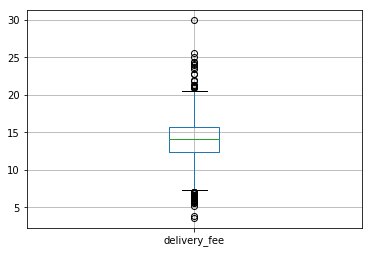

In [101]:
bp = outlier_csv.boxplot(column='delivery_fee')

In [102]:
outlier_csv['delivery_fee'].describe()

count    500.000000
mean      13.928537
std        3.490627
min        3.568045
25%       12.318951
50%       14.054261
75%       15.648504
max       29.945278
Name: delivery_fee, dtype: float64

## 3.1 ESD method to check outliers

In this part, we are going to use ESD method to check outliers. According to ESD method, we use the function
( if |x-mean(x)| > 3*sd(x), x is outlier ) to solve this problem. Use the function of `np.mean` and `np.std` to transfer the `delivery_fee` respectively, then bring the data into the formula to calculate. Finally, apply the data

In [103]:
mean_fee = np.mean(outlier_csv['delivery_fee'])
sd_fee = np.std(outlier_csv['delivery_fee'])
def ESD_outliers(data):
    z = abs((data['delivery_fee']-mean_fee)/sd_fee) ##|x-mean(x)| / sd(x)
    return z > 3

In [104]:
outlier_csv[outlier_csv.apply(ESD_outliers,axis = 1)]

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
204,ORDK06351,2018-12-30,20:00:00,Dinner,BK,"[('Salmon', 2), ('Pasta', 3), ('Shrimp', 3), (...",431.5,-37.815485,144.937798,0,9.984,29.945278
353,ORDX01507,2018-10-06,17:07:36,Dinner,BK,"[('Fish&Chips', 2), ('Salmon', 10)]",480.0,-37.817461,144.967420,0,7.455,25.577977
378,ORDX09132,2018-06-17,13:24:30,Lunch,BK,"[('Fries', 8), ('Chicken', 1)]",128.0,-37.802166,144.964518,0,7.721,25.023267


## 3.2 MAD( median absolute deviation) method to check outliers

In this part, we are going to use MAD ( median absolute deviation) method to check outliers. According to MAD method, we use the function ( x is an outlier if |x-median(x)| > 3*sd(x) ) to solve this problem. Use the function of np.median to transfer the delivery_fee, then bring the data into the formula to calculate. Finally, apply the data

In [105]:
median_fee = np.median(outlier_csv['delivery_fee'])
def MAD_outliers(data):
    z = abs((data['delivery_fee']-median_fee)/sd_fee) ##|x-median(x)| / sd(x)
    return z > 3

In [106]:
outlier_csv[outlier_csv.apply(MAD_outliers,axis = 1)]

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
57,ORDB07956,2018-01-08,08:10:08,Breakfast,TP,"[('Coffee', 2), ('Cereal', 4), ('Eggs', 3)]",165.0,-37.816161,144.939029,1,10.284,3.568045
204,ORDK06351,2018-12-30,20:00:00,Dinner,BK,"[('Salmon', 2), ('Pasta', 3), ('Shrimp', 3), (...",431.5,-37.815485,144.937798,0,9.984,29.945278
353,ORDX01507,2018-10-06,17:07:36,Dinner,BK,"[('Fish&Chips', 2), ('Salmon', 10)]",480.0,-37.817461,144.967420,0,7.455,25.577977
378,ORDX09132,2018-06-17,13:24:30,Lunch,BK,"[('Fries', 8), ('Chicken', 1)]",128.0,-37.802166,144.964518,0,7.721,25.023267


Remove the outlier from csv and use the function of describe to check data

In [107]:
##remove the outlier from csv
outlier_csv.drop(outlier_csv[outlier_csv.apply(MAD_outliers,axis = 1)].index.values,inplace = True)

In [108]:
outlier_csv['delivery_fee'].describe()

count    496.000000
mean      13.871278
std        3.319897
min        3.858131
25%       12.318951
50%       14.024532
75%       15.642541
max       24.372530
Name: delivery_fee, dtype: float64

Set the unified `delivery_fee` to original and use the function of boxplot to see the data

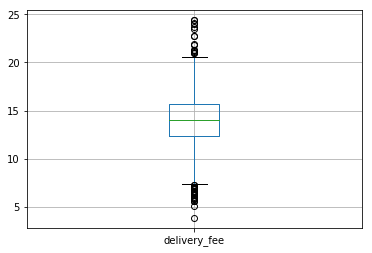

In [109]:
bp = outlier_csv.boxplot(column='delivery_fee')

## Save into csv file

In [110]:
outlier_csv.to_csv('Group023_outlier_data_solution.csv')

## Summary

This assessment measured the understanding of basic csv file processing techniques in the Python programming language and use exploratory data analysis (EDA) method to check data and use the different ways to solve or fill the data into the files.

- **dirty_data.csv** First of all, use the EDA method to check whether have errors in each columns. In `1.2 date`, use the function of `pd.to_datetime` to fix the date as same format. In `1.3 time`, use the boolean function to check the data wether is same format (hour, minute and second). In `1.4 Order type`, fix error in column, because some types occurs on wrong  time range. In `1.5 Branch code`, change all of branch into uppercase. And based on the `outlier.csv`, we found some errors that some of branch_code do not fit order_id. In `1.6 Order item`, find the correct menu for each items, using `re (regular expression)` to extract data and caculate the menu price. Notably, we only get the colunm which has 4 order_items, it makes easier to caculate the price of each item. In the `replace the wrong menu` part, utilize division method to know whic item is correct. In `1.7 Order_price`, find and fix the error in order price. In `1.8 Customer lat & lon`, use the data visualization to check errors and set conditions to fix it. In `1.9 customerHasloyalty?`, check wether it has orther value except 0 and 1. In `1.10 distance_to_customer_KM`, firstly, merge the data. Secondly, create tje bilateral edges. Finally, caculate the shortest distance. In `1.11 delivery fee`, use the data visualization to see between each branch and deliver fee.



- **missing_data.csv** In this part, we are going to fill `branch_code` by using the informations(relationship between order_id and branch_code). And merge `missing_data.csv`, `nodes.csv` and `branch.csv` to get the branch_node and customer_node. And set these two values as input to get the missing `distance_to_customer_KM`. Finally, using `Linear Regression` to calculate the `delivery_fee`



- **outlier_data.csv** In this part, use the different methods to check outliers and use data visualization to check data. Firstly, use the `ESD method` to check outliers `( if |x-mean(x)| > 3*sd(x), x is outlier )`. Secondly, use `MAD( median absolute deviation)` method to check outliers `( x is an outlier if |x-median(x)| > 3*sd(x) )`. Finally, remove the outlier from the file.

## Reference

- The `pandas` Project. (2016a). *pandas 0.19.2 documentation: pandas.DataFrame.to_csv*. Retrieved from http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_csv.html#pandas.DataFrame.to_csv
- wikipedia — exploratory data analysis (EDA)*. Retrieved from https://en.wikipedia.org/wiki/Exploratory_data_analysis
- Linear Regression in Python – Real Python*. Retrieved from https://realpython.com/linear-regression-in-python/
- Python Arrays - W3Schools*. Retrieved from https://www.w3schools.com/python/python_arrays.asp
- Python Program to Solve Quadratic Equation*. Retrieved from https://www.programiz.com/python-programming/examples/quadratic-roots